In [82]:
from __future__ import division
import numpy
import pandas
import matplotlib.pyplot as plt
from numpy import matrix, linalg, linspace, interp, asarray, argmax
from scipy.integrate import odeint
from scipy.stats import linregress 
%matplotlib inline
#%matplotlib notebook

### Continuous fermentation

Most bulk scale chemical processes are operated in continuous mode, consider for example the traditional petrochemical refinery. Continuous operation offers the advantage of stability, where conditions remain the same over extended periods of time. The non-production time in expensive equipment is minimised with continuous production, while optimal conditions can be targeted at steady state.

Fermentation processes can also operate at steady state. Although commercial continuous processes exist, the status quo is batch and fed-batch operation. It is much easier to operate a batch fermentation, especially in the lab, where small scale explorations establish the platform for commercial development. This is likely to change in the age of the biorefinery, where optimisation of bulk scale fermentation processes will become more important.

Continuous fermentation holds some practical challenges. Long term sterility can be an issue, where infections from unwanted organisms can kill a process and cause major material losses. Genetic stability of modified microbes can also be an issue, where strain regression can occur over extended periods of operation. With proper engineering these challenges can be overcome.

In the lab continuous fermentation has advantages over conventional batch fermentation. The main advantage is that the microbe can be operated at steady state by keeping all the conditions in the fermenter constant. It is much easier to understand and investigate the physiology of an organism if it is ‘standing still’. In a batch system conditions are always changing and it becomes harder to investigate the effect of the conditions on the organism. Unfortunately continuous fermentation on small scale require specialized equipment, where a batch fermentation can be as easy as putting a flask in a temperature controlled shaker, accordingly 95% of fermentation literature is based on batch of fed-batch fermentation.

In this last section of the course we'll introduce the chemostat. The example will show how steady state is reached when the inlet flowrate to the fermenter is equal to the outlet flowrate. We will show how the differential part of the cmol balance becomes zero and how an algebraic equation that describes steady state results. It will be shown how the growth rate of the organism can be controlled by merely adjusting the feed (and exit) flowrates. We will use the same system as in [section 7.1](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/7%20Fed-batch%20and%20continuous%20fermenters/Fed-batch%20fermenters.ipynb).



<img src="lacmap1.png" width="450" />

The following physiological parameters will be used:


|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$
|----|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$
|0.05|1.8|0.4|0.09

Let's assume the standard biomass formula of $CH_{1.8}O_{0.5}N_{0.2}$.

The growth and maintenance functions are given below. **Note that substrate inhibition used in section 7.1 is now omitted from the growth function.**

$$\mu=\mu_{max}\left[\frac{Cs}{Km+Cs}\right] \left[1+\frac{C_P}{K_P} \right]^{-1} $$

$$\theta=\theta_{max}\left[\frac{Cs}{Km+Cs}\right]$$

Parameters are defined in the cell below:


In [83]:
Km, Kp, Ks = 0.001, 2, 5

In [84]:
alpha = 0.05
gamma = 1.8
mumax = 0.4
thetamax = 0.09

The following video might be helpful:

[Video: Lecture 19: Continuous fermentation](https://youtu.be/iuuq0p1QeaY)

<img src="cont.png" width="400" />

We are now going to operate the fermenter by continuously feeding substrate at a flowrate of $Q$, while simultaneously removing liquid from the fermenter at the same flowrate ($Q$). Like before we start by using  cmol component balance given in [section 5.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/5%20Basic%20bioreactor%20modeling/The%20fermenter%20equation.ipynb):

$$\frac{dN_i}{dt}=Q C^F_i-QC_i  + r_i C_X V $$

Given that the inlet and outlet flowrates are the same, the volume in the fermenter will remain unchanged. The above equation can thus be rewritten as follow:

$$\frac{dC_i}{dt}=\frac{Q}{V}(C^F_i-C_i) + r_i C_X  $$  

Note that the outlet concentration ($C_i$) is the same as the concentration in the well mixed fermenter. The inlet concentration
($C^F_i$) needs to be specified.


In [85]:
Cfs=68/30  #cmol/l

Note from the specification above that only glucose is fed to the fermenter. Accordingly no cells or lactic acid is fed. The 3 balances can be written separately:

$$\frac{dC_S}{dt}=\frac{Q}{V}(C^F_S-C_S) + r_S C_X  $$

$$\frac{dC_X}{dt}=-\frac{Q}{V}C_X + r_X C_X  $$

$$\frac{dC_P}{dt}=-\frac{Q}{V}C_P + r_P C_X  $$



The equations above look very similar to the batch fermenter equations of the **ferm_function**. There is however additional terms. The **response_fun** will however remain exactly the same as before.

Use the following conditions and model the fermenter for 400 hours.

In [86]:
Cxo, Cso, Claco = 0.003, 0 , 0 #cmol/L
V, Qf = 1000, 250     #L and L/h 

You should get something like this:

<img src="cont_dyn1.png" width="550" />

In [87]:
def response_fun(C):
    
    Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
    Cp = Clac
                                       
    mu1=mumax*(Cs/(Km + Cs))*((1 + (Cp/Kp))**(-1))
    theta=thetamax*(Cs/(Km + Cs))
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
  
    Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                          [0,(-1)*gamma,1/3]])
    
    S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)             
    
    return [r[1,0],   # important to see the order of the rates (X,S,LAC)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[2,0]]   # LAC

In [88]:
def ferm_eq(C,t):
    Cx, Cs, Clac= C[0],C[1],C[2]  #order of components very important 
    r=response_fun([Cx, Cs, Clac])# this is the 'fetching' from the response function
    
    return [r[0]*Cx - (Qf*Cx)/V,          #X
            r[1]*Cx + (Qf/V)*(Cfs - Cs),  #glucose
            r[2]*Cx - (Qf*Clac)/V]        #LA

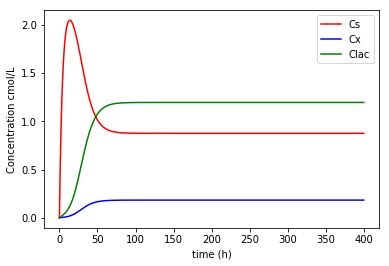

In [89]:
Co=[Cxo, Cso, Claco]                     # [Cxo, Cso, Cpo] in cmol/L
tmax=400                                    
tspan=numpy.linspace(0,tmax,400)           
Ci = odeint(ferm_eq, Co, tspan)

Cx=Ci[:,0]                                  
Cs=Ci[:,1]
Clac=Ci[:,2]

plt.figure(1)
plt.plot(tspan, Cs, color='red',label='Cs')
plt.plot(tspan, Cx, color='blue',label='Cx')
plt.plot(tspan, Clac, color='green', label='Clac')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

Repeat the simulation, but this time put some glucose in the fermenter beforehand:

In [90]:
Cso=60/30  #cmol/L

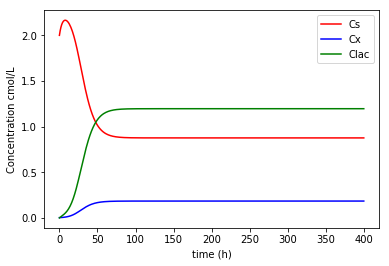

In [91]:
Co=[Cxo, Cso, Claco]                     # [Cxo, Cso, Cpo] in cmol/L
tmax=400                                    
tspan=numpy.linspace(0,tmax,400)           
Ci = odeint(ferm_eq, Co, tspan)

Cx=Ci[:,0]                                  
Cs=Ci[:,1]
Clac=Ci[:,2]

plt.figure(2)
plt.plot(tspan, Cs, color='red',label='Cs')
plt.plot(tspan, Cx, color='blue',label='Cx')
plt.plot(tspan, Clac, color='green', label='Clac')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

You should now get something like this:

<img src="cont_dyn2.png" width="550" />

Compare the final 'steady state' condition. Is there is difference? 

No difference in the final steady state.

Now reduce $C_X^o$ to zero. What do you obtain and why?

In [92]:
Cxo = 0

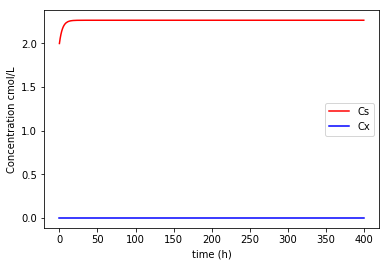

In [93]:
Co=[Cxo, Cso, Claco]                     # [Cxo, Cso, Cpo] in cmol/L
tmax=400                                    
tspan=numpy.linspace(0,tmax,400)           
Ci = odeint(ferm_eq, Co, tspan)

Cx=Ci[:,0]                                  
Cs=Ci[:,1]
Clac=Ci[:,2]

plt.figure(3)
plt.plot(tspan, Cs, color='red',label='Cs')
plt.plot(tspan, Cx, color='blue',label='Cx')
#plt.plot(tspan, Clac, color='green', label='Clac')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

There needs to be growth in the cell to keep increasing production of Latose. The biomass is the bug, so one needs to inocculate the mixture with some biomass to get things rolling. Something needs to be there to chomp the glucose.

We can see that there is zero concentration change at the end of the run, thus $\frac{dC_i}{dt}=0$. At steady state we thus have the following:

$$\frac{Q}{V}(C^F_S-C_S) + r_S C_X = 0 $$

$$-\frac{Q}{V}C_X + r_X C_X  = 0 $$

$$-\frac{Q}{V}C_P + r_P C_X = 0 $$

Above we have 3 equations with 3 unknowns ($C=[C_S, C_X, C_P]$). Unlike our matrix formulations these 3 equations are non-linear, just consider the $\mu=r_X$ function (part of the **response_fun**). It is relatively simple to solve the system of 3 non-linear algebraic equations using the Python function **fsolve**.

As example, take the following system of two non-linear equations:

$$y=0.02x^2$$

$$y=\frac{2}{x}$$

Let's quickly plot these functions:


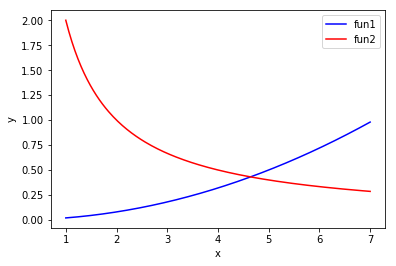

In [94]:
xspan=numpy.linspace(1,7,200)  
plt.figure(4)
plt.plot(xspan, 0.02*xspan**2, color='blue', label='fun1')
plt.plot(xspan, 2/xspan, color='red', label='fun2')

plt.legend(loc='best')
plt.ylabel('y') 
plt.xlabel('x') 
plt.show()

The intersection on the graph above gives the **x** and **y** value where both equations are satisfied, it is therefore a root of the two-equation system. We can easily obtain these values with **fsolve**. We start by defining a function of the two equations:  

In [95]:
def fun_algebra(C):
    y, x = C[0], C[1]
       
    return [y-0.02*x**2,
            y-2/x]            

In [96]:
from scipy.optimize import fsolve
ans=fsolve(fun_algebra,[1,1])  #Get estimate from graph above
ans

array([0.43088694, 4.64158883])

Note that the function **fsolve** requires an estimate for the answers. The estimate provided in the example was $[1,1]$. An answer is not always guaranteed when using **fsolve**. The root-finding algorithm depends on the accuracy of the initial guess. It is also possible to obtain multiple roots, so be careful in using **fsolve** blindly. It is very easy to test the answer by merely substituting into the function:  

In [97]:
print(fun_algebra(ans))

[8.032463583163008e-14, -5.257017043902579e-12]


What do the values above mean?

Let's see if you can use **fsolve**. Take the 3 steady state component cmol balances and see whether you can obtain the same steady state concentrations as the final values from the integration. The answers will be close to identical. Your equivalent of the **fun_algebra** function will be very similar to the old **ferm_eq** function that calls upon the **response_fun**, but there won't be any differentials, only algebraic equations. 

Be careful when performing the initial guess. To be realistic the root must obey the following:

$$0<C_S < C_S^F$$

$$0<C_P < Y_{SP}^{max}C_S^F$$

$$0<C_X < Y_{SX}^{max}C_S^F$$

You should get the following $C=[C_X, C_S, C_P]$ : **[0.18465745,  0.87642339,  1.19635296]**


In [98]:
def algebra_fun(C):
    Cx, Cs, Clac= C[0],C[1],C[2]  #order of components very important 
    r=response_fun([Cx, Cs, Clac])# this is the 'fetching' from the response function
    
    return [r[0]*Cx - (Qf*Cx)/V,          #X
            r[1]*Cx + (Qf/V)*(Cfs - Cs),  #glucose
            r[2]*Cx - (Qf*Clac)/V]        #LA

In [99]:
Co=[0.1,0,0]                     # [Cxo, Cso, Clao] in cmol/L

ans=fsolve(algebra_fun, Co)  #Get estimate from graph above
ans

array([0.18465745, 0.87642339, 1.19635296])

Once you are able to solve for a steady state condition, you can vary the throughput (flow through the fermenter).

Reduce the flowrate to 50 $\frac{L}{h}$. You should get the following $[C_X, C_S, C_P]$ : **[0.2910506, 3.28984e-04,   1.960734]**

In [100]:
Qf = 50

In [101]:
Co1=[0.1,0,0]                     # [Cxo, Cso, Clao] in cmol/L

ans=fsolve(algebra_fun, Co1)  #Get estimate from graph above
ans

array([2.91050604e-01, 3.28984734e-04, 1.96073455e+00])

The productivity of the chemostat (continuous fermenter) is merely the volumetric production rate of product ($r_P^V$). Play around with the flowrate ($Q$) and determine the maximum lactic acid productivity. **[P = 11.5 $\frac{g}{L \cdot h}$]**

<img src="prod_cont.png" width="550" />



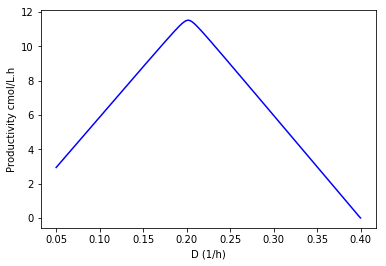

11.527737723164167

In [102]:
Qf2 = linspace(50,400,400)
D = Qf2/V
P=[]

for vals in Qf2:
    Qf = vals     
    
    def response_fun(C):
            
        Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
        Cp = Clac
                                       
        mu1=mumax*(Cs/(Km + Cs))*(1/(1 + (Cp/Kp)))
        theta=thetamax*(Cs/(Km + Cs))
    
        if mu1 < 0.0001:   #Negative values of mu set to zero
            mu=0 
        else:
            mu=mu1
  
        Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                             [0,(-1)*gamma,1/3]])
    
        S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
        C= numpy.matrix([[0,theta, mu]]).T
        r = numpy.linalg.solve(S1,C)             
    
        return [r[1,0],   # important to see the order of the rates (X,S,LAC)
               -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
                r[2,0]]   # LAC
        
      
    def algebra_fun(C):
        Cx, Cs, Clac= C[0],C[1],C[2]  #order of components very important 
        r=response_fun([Cx, Cs, Clac])# this is the 'fetching' from the response function
    
        return [r[0]*Cx - (Qf*Cx)/V,          #X
                r[1]*Cx + (Qf/V)*(Cfs - Cs),  #glucose
                r[2]*Cx - (Qf*Clac)/V]        #LA
    
    Co2=[0.1,0,0]                     # [Cxo, Cso, Clao] in cmol/L
    
    ans=fsolve(algebra_fun, Co2)  #Get estimate from graph above
    
    rates = [response_fun(ans)]
    
    rp_v = rates[0][2]*ans[0]*30
    
    P.append(rp_v)
    
    
plt.figure(5)
plt.plot(D,P, color='blue', label='Cp')
plt.ylabel('Productivity cmol/L.h') 
plt.xlabel('D (1/h)') 
plt.show()

Pmax = max(P)
Pmax

Compare this to the productivity of a batch fermenter, where $C_S^o$ is the same as the glucose feed concentration of the chemostat ($C_S^F$). Use the same $C_X^o$ as specified before. **[P = 4.2 $\frac{g}{L \cdot h}$]**

Why is the chemostat so much more productive? Think long and hard and talk to your group about your ideas.

In [103]:
CoBatch = (0.003,68/30, 0)

In [104]:
def ferm_batch(C,t):
    Cx, Cs, Clac= C[0],C[1],C[2] # order of components very important 
    r=response_fun([Cx, Cs, Clac])      # this is the 'fetching' from the response function
    
    return [r[0]*Cx,    #X
            r[1]*Cx,    #glucose
            r[2]*Cx]    #LA

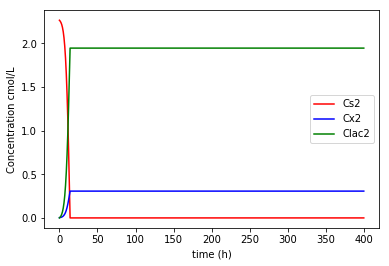

In [105]:
tmax2=400                                    
tspan2=numpy.linspace(0,tmax2,400)           
Ci2 = odeint(ferm_batch, CoBatch, tspan2)

Cx2=Ci2[:,0]                                  
Cs2=Ci2[:,1]
Clac2=Ci2[:,2]

plt.figure(6)
plt.plot(tspan2, Cs2, color='red',label='Cs2')
plt.plot(tspan2, Cx2, color='blue',label='Cx2')
plt.plot(tspan2, Clac2, color='green', label='Clac2')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

In [106]:
tdone = interp(0.001,Cs2[::-1],tspan2[::-1])
tdone

14.032421998644907

In [107]:
Pbatch = max(Clac2)/tdone*30
Pbatch

4.162750648641024

We haven't even included a substrate inhibition factor for the response function. By controlling the Qf, we can maximise the steady state concentrations, and get the optimal productivity, as opposed to feeding all the glucose all at once. At steady state, the throughput directly controls the growth rate, as explained in the next section.

### Dilution rate (D)

In fermentation nomenclature the throughput is defined by the dilution rate (D) where:

$$D=\frac{Q}{V}$$
---

If we take the steady state cmol balance of biomass, an interesting result is obtained:

$$-\frac{Q}{V}C_X + r_X C_X  = 0 $$

$$ -DC_X + \mu C_X = 0$$

$$ D=\mu$$
---

Wow! So the throughput directly controls the growth rate! We can thus adjust the $\mu$ value by adjusting $Q$.

Okey, so the aim is to get $\mu$ high. Let's specify a $\mu =D$ value of $0.5 \frac{1}{h}$ and see what is obtained. Check your algebraic calculation by also performing an integration (time dependant solution of steady state). Use a $C_S^o$ value of $2 \frac{cmol}{L}$ and a $C_X^o$ value of $0.3 \frac{cmol}{L}$ while $C_S^F$ remains the same as before. What is happening here?

<img src="washout.png" width="550" />


In [108]:
Cso, Cxo, Csf = 2, 0.3, 68/30
QfD = 500  #Q/V must equal to 0.5 as it is equal to mu

In [109]:
def response_D(C):
    
    Cx, Cs, Clac= C[0],C[1],C[2]  #Same component order as in the ferm-eq
    Cp = Clac
                                       
    mu1=mumax*(Cs/(Km + Cs))*((1 + (Cp/Kp))**(-1))
    theta=thetamax*(Cs/(Km + Cs))
    
    if mu1 < 0.0001:   #Negative values of mu set to zero
        mu=0 
    else:
        mu=mu1
  
    Sbase = numpy.matrix([[-1,(1+alpha),1],   #Stoichiometric matrix without specification (4x5)
                          [0,(-1)*gamma,1/3]])
    
    S1 = numpy.vstack([Sbase,[0,1,0]])  #Stoich matrix with growth spec
      
    C= numpy.matrix([[0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)             
    
    return [r[1,0],   # important to see the order of the rates (X,S,LAC)
           -r[0,0],   # glucose, note the negative since the flux model calculated (-rs)
            r[2,0]]   # LAC

In [110]:
def algebra_D(C):
    Cx, Cs, Clac= C[0],C[1],C[2]  #order of components very important 
    r=response_D([Cx, Cs, Clac])# this is the 'fetching' from the response function
    
    return [r[0]*Cx - (Qf*Cx)/V,          #X
            r[1]*Cx + (Qf/V)*(Cfs - Cs),  #glucose
            r[2]*Cx - (Qf*Clac)/V]        #LA

In [111]:
CoD=[Cxo,Cso,0]                     # [Cxo, Cso, Clao] in cmol/L

ans=fsolve(algebra_D, CoD)  #Get estimate from graph above
ans

array([5.85773764e-14, 2.26666667e+00, 3.55840144e-13])

In [112]:
def ferm_D(C,t):
    Cx, Cs, Clac= C[0],C[1],C[2]  #order of components very important 
    r=response_fun([Cx, Cs, Clac])# this is the 'fetching' from the response function
    
    return [r[0]*Cx - (QfD*Cx)/V,          #X
            r[1]*Cx + (QfD/V)*(Cfs - Cs),  #glucose
            r[2]*Cx - (QfD*Clac)/V]        #LA

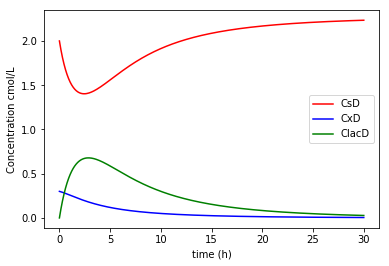

In [113]:
tmaxD=30                                   
tspanD=numpy.linspace(0,tmaxD,400)           
CiD = odeint(ferm_D, CoD, tspanD)

CxD=CiD[:,0]                                  
CsD=CiD[:,1]
ClacD=CiD[:,2]

plt.figure(7)
plt.plot(tspanD, CsD, color='red',label='CsD')
plt.plot(tspanD, CxD, color='blue',label='CxD')
plt.plot(tspanD, ClacD, color='green', label='ClacD')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

All the production concentrations are zero because the system has been washed out. In other words, the Qf is so high, there is not enough time for production of lactic acid, they're all flushed out before any measurable concentration can build.

Reduce the D value and replot the dynamic response, while checking the algebraic steady state root. 

In [114]:
QfD1 = 200

In [115]:
def fprint(s, i=2):
    print(("{:."+str(i)+"f}").format(s))

In [116]:
CoD1=[Cxo,Cso,0]                     # [Cxo, Cso, Clao] in cmol/L

ans=fsolve(algebra_D, CoD1)  #Get estimate from graph above
ans

array([5.85773764e-14, 2.26666667e+00, 3.55840144e-13])

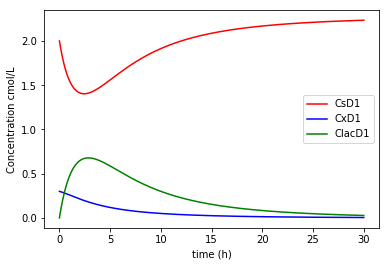

In [117]:
tmaxD1=30                                   
tspanD1=numpy.linspace(0,tmaxD1,400)           
CiD1 = odeint(ferm_D, CoD1, tspanD1)

CxD1=CiD1[:,0]                                  
CsD1=CiD1[:,1]
ClacD1=CiD1[:,2]

plt.figure(7)
plt.plot(tspanD1, CsD1, color='red',label='CsD1')
plt.plot(tspanD1, CxD1, color='blue',label='CxD1')
plt.plot(tspanD1, ClacD1, color='green', label='ClacD1')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

So there you have it. It is possible to have stable steady state operation at higher productivities than the that of the batch fermenter. No integration required to solve for steady state. Response function remains identical (like always). **Fsolve** is a convenient tool for solving sets of non-linear algebraic equations. There is a throughput limit linked to the maximum growth rate.